In [1]:
import shutil
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt

from lib import (
    load_exp_conf,
    load_exp_data,
    P3innDir,
    pi3nn_compute_PI_and_mean,
    FinnDir,
    finn_fit_retardation,
    interp1D_torch,
    solve_diffusion_sorption_pde,
    FinnParams,
    compute_core2B_profile,
)

# Run

In [2]:
data_out_root = Path("../data_out").resolve()
assert data_out_root.exists()
pi3nn_root = data_out_root / "p3inn"
finn_root = data_out_root / "finn"
pi3nn_root.mkdir(exist_ok=True, parents=True)
finn_root.mkdir(exist_ok=True, parents=True)

In [3]:
data_core2_df = load_exp_data(name="Core 2")
display(data_core2_df.head())

,time,c_diss
0,0.000000,0.000000
1,0.838329,0.000096
2,1.377912,0.000062
3,1.879996,0.000061
4,2.379996,0.000052


### PI3NN on experimental data to obtain PIs for different quantiles

In [4]:
# p3inn_core2_dir = P3innDir(pi3nn_root / "core2")
# shutil.rmtree(p3inn_core2_dir.path.absolute())
p3inn_core2_dir = P3innDir(pi3nn_root / "core2")
np.save(p3inn_core2_dir.x_data_path, data_core2_df["time"].to_numpy().reshape(-1, 1))
np.save(p3inn_core2_dir.y_data_path, data_core2_df["c_diss"].to_numpy().reshape(-1, 1))

quantiles = [1.0 - 0.05 * i for i in range(1, 10)]
pi3nn_compute_PI_and_mean(
    out_dir=p3inn_core2_dir.path,
    quantiles=quantiles,
)

### FINN on all quantiles to obtain retardations

In [5]:
finn_exp_root = finn_root / "p3inn_core2_new"
finn_exp_root

PosixPath('/Users/r/Documents/stud/ss24/finnpinn/data_out/finn/p3inn_core2_new')

In [6]:
conf_core2 = load_exp_conf(name="Core 2")
display(conf_core2)

{'D': 2.0045664000000002e-05,
 'por': 0.288,
 'rho_s': 1957.0,
 'X': 0.026034999999999996,
 'T': 39.824440010000004,
 'Nx': 20.0,
 'Nt': 55.0,
 'sample_radius': 0.02375,
 'Q': 0.00010435199999999999,
 'solubility': 1.6,
 'Dirichlet': 0.0,
 'Cauchy': 1.0}

In [ ]:
import numpy as np
import os
import multiprocessing
from multiprocessing import Pool
from functools import partial

def check_convergence_and_restart(finn_p3inn_core2_dir, conf_core2):
    # Function to check convergence and handle restarts
    mse_threshold = 2e-8

    # Check if experiment is done
    if finn_p3inn_core2_dir.is_done:
        # Load the predicted and training data
        pred_data = np.load(finn_p3inn_core2_dir.get_data_pred_path(finn_p3inn_core2_dir.best_epoch))
        train_data = np.load(finn_p3inn_core2_dir.c_train_path)
        
        # Calculate MSE
        mse = np.mean((pred_data - train_data) ** 2)
        
        # Check if MSE is below the threshold
        if mse < mse_threshold:
            print(f"Convergence achieved for {finn_p3inn_core2_dir.path}. MSE: {mse}")
            return True  # Convergence achieved
        else:
            # If done but not converged, delete done marker and retry
            print(f"Experiment finished but did not converge for {finn_p3inn_core2_dir.path}. Restarting...")
            os.remove(finn_p3inn_core2_dir.done_marker_path)

    # Run the experiment
    print(f"Running experiment for {finn_p3inn_core2_dir.path}")
    finn_fit_retardation(
        out_dir=finn_p3inn_core2_dir.path,
        is_exp_data=True,
        n_epochs=21,
        **conf_core2,
    )
    return False  # Not converged

def run_experiment(quantile, bound_type, bound, conf_core2, data_core2_df, finn_exp_root):
    # Prepare FinnDir for the given quantile and bound type
    finn_p3inn_core2_dir = FinnDir(finn_exp_root / f"{bound_type}_{quantile:g}")
    
    # Save the training data and time array
    np.save(finn_p3inn_core2_dir.c_train_path, np.squeeze(bound))
    t = np.linspace(data_core2_df["time"].min(), data_core2_df["time"].max(), len(bound))
    np.save(finn_p3inn_core2_dir.t_train_path, t)
    
    print(f"{finn_p3inn_core2_dir.path.relative_to(finn_exp_root)}")

    # Restart loop until convergence is achieved
    converged = False
    while not converged:
        converged = check_convergence_and_restart(finn_p3inn_core2_dir, conf_core2)

def parallel_experiments(conf_core2, data_core2_df, p3inn_core2_dir, finn_exp_root):
    # Collect all tasks for parallel execution
    tasks = []
    for quantile, bound_up, bound_down in p3inn_core2_dir.iter_pred_PIs():
        for bound_type, bound in [("up", bound_up), ("down", bound_down)]:
            tasks.append((quantile, bound_type, bound))
    
    # Set up the partial function with shared parameters
    partial_run_experiment = partial(
        run_experiment,
        conf_core2=conf_core2,
        data_core2_df=data_core2_df,
        finn_exp_root=finn_exp_root
    )
    
    # Use multiprocessing pool to parallelize the experiments
    with Pool(processes=multiprocessing.cpu_count()) as pool:
        pool.starmap(partial_run_experiment, tasks)


parallel_experiments(conf_core2, data_core2_df, p3inn_core2_dir, finn_exp_root)


up_0.55
down_0.55
up_0.6
down_0.6
up_0.65
down_0.65
It   1/21 | mse = 2.90e-08 | loss = 3.77e-01 | dt = 35.0s | lr = 1.0e-01 | loss_mse = 2.9e-03 | loss_phys = 0.0e+00


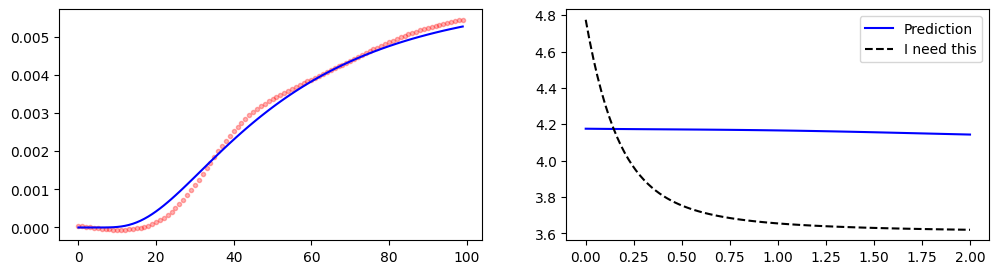

It   2/21 | mse = 2.55e-08 | loss = 2.83e-03 | dt = 34.2s | lr = 9.7e-02 | loss_mse = 2.6e-03 | loss_phys = 0.0e+00


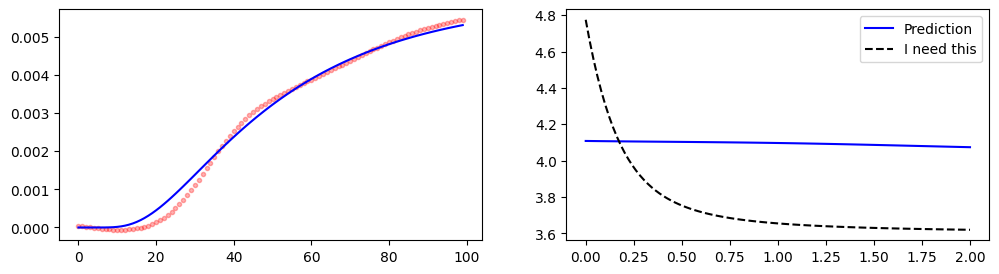

It   3/21 | mse = 2.54e-08 | loss = 2.55e-03 | dt = 34.4s | lr = 8.9e-02 | loss_mse = 2.5e-03 | loss_phys = 0.0e+00


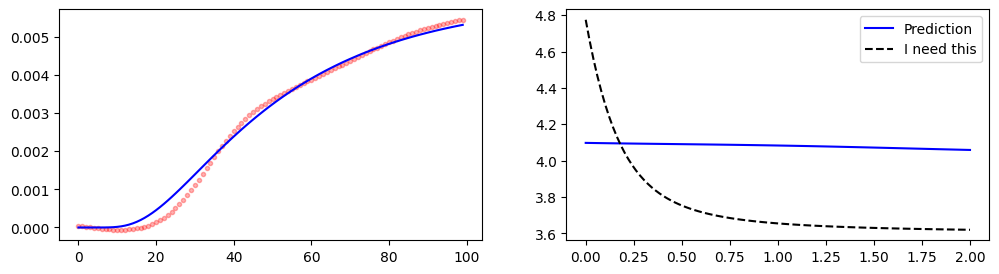

It   4/21 | mse = 2.52e-08 | loss = 2.54e-03 | dt = 34.4s | lr = 7.7e-02 | loss_mse = 2.5e-03 | loss_phys = 0.0e+00


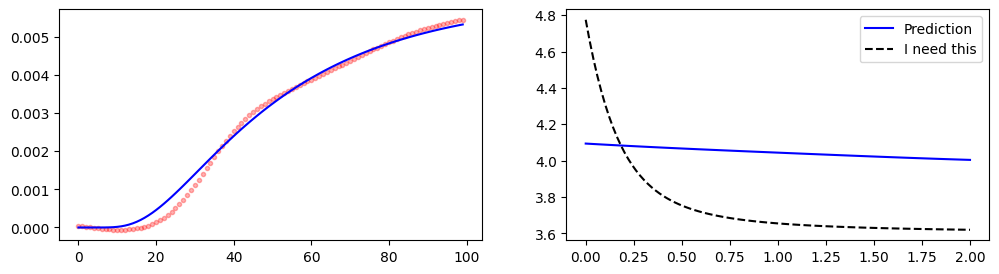

It   5/21 | mse = 1.85e-08 | loss = 2.52e-03 | dt = 35.5s | lr = 6.3e-02 | loss_mse = 1.9e-03 | loss_phys = 0.0e+00


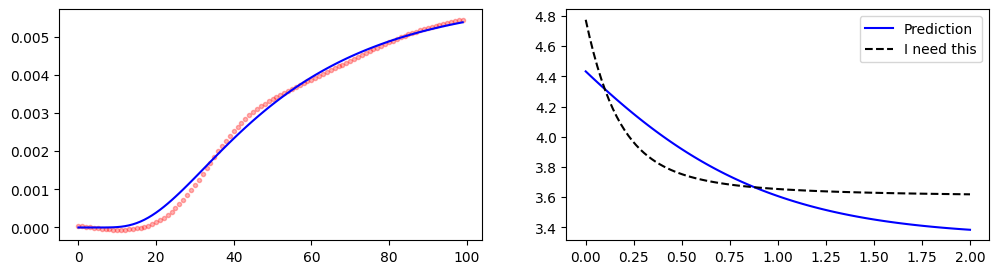

It   6/21 | mse = 1.77e-08 | loss = 1.85e-03 | dt = 38.5s | lr = 4.7e-02 | loss_mse = 1.8e-03 | loss_phys = 0.0e+00


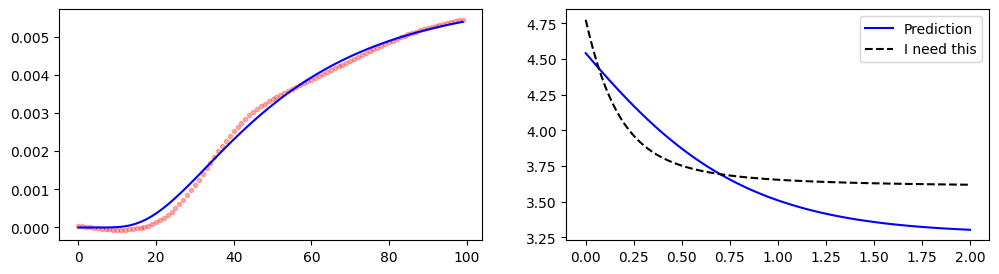

It   7/21 | mse = 1.74e-08 | loss = 1.77e-03 | dt = 39.5s | lr = 3.3e-02 | loss_mse = 1.7e-03 | loss_phys = 0.0e+00


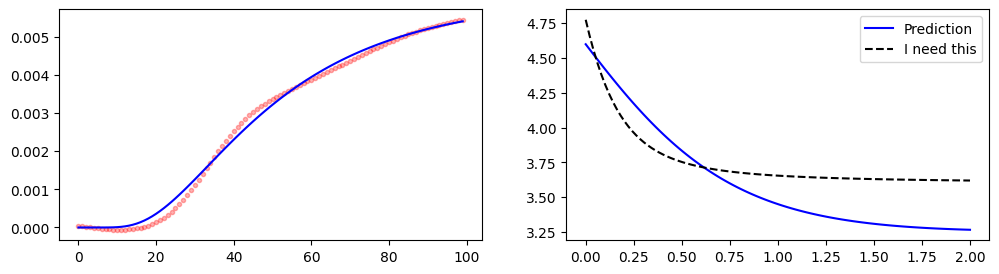

It   8/21 | mse = 1.74e-08 | loss = 1.74e-03 | dt = 39.9s | lr = 2.1e-02 | loss_mse = 1.7e-03 | loss_phys = 0.0e+00


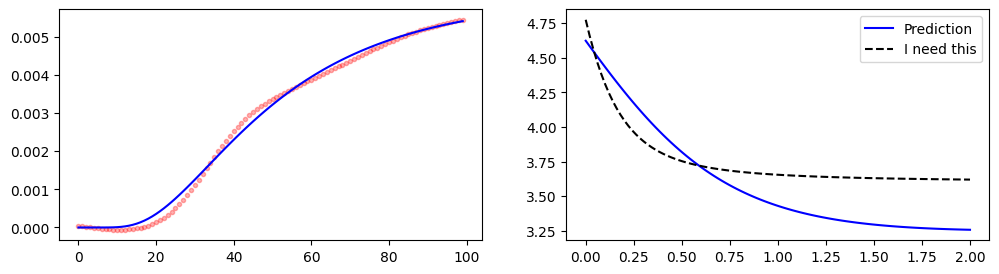

It   9/21 | mse = 1.73e-08 | loss = 1.74e-03 | dt = 40.0s | lr = 1.3e-02 | loss_mse = 1.7e-03 | loss_phys = 0.0e+00


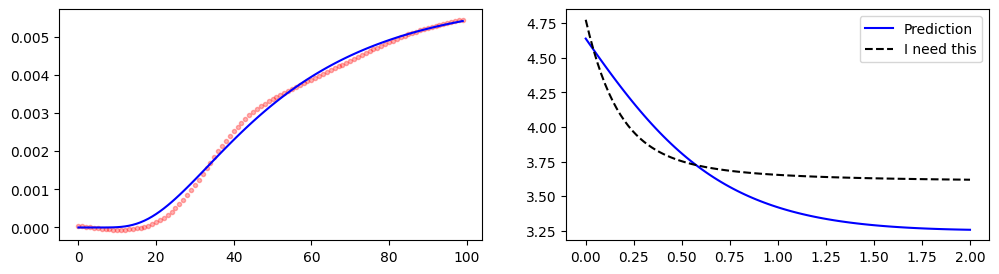

It  10/21 | mse = 1.73e-08 | loss = 1.73e-03 | dt = 39.9s | lr = 1.0e-02 | loss_mse = 1.7e-03 | loss_phys = 0.0e+00


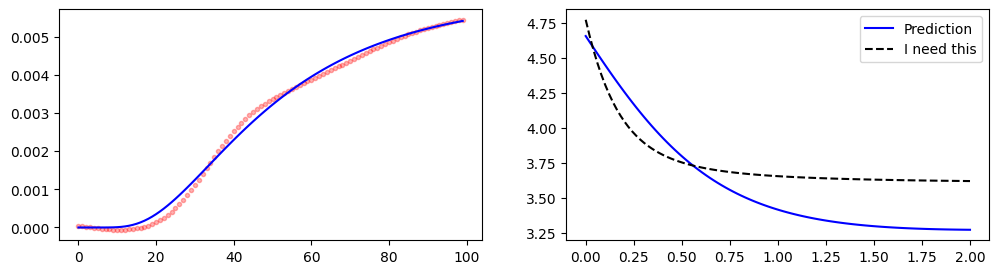

It  11/21 | mse = 1.17e-05 | loss = 1.73e-03 | dt = 193.5s | lr = 8.0e-02 | loss_mse = 1.2e+00 | loss_phys = 0.0e+00


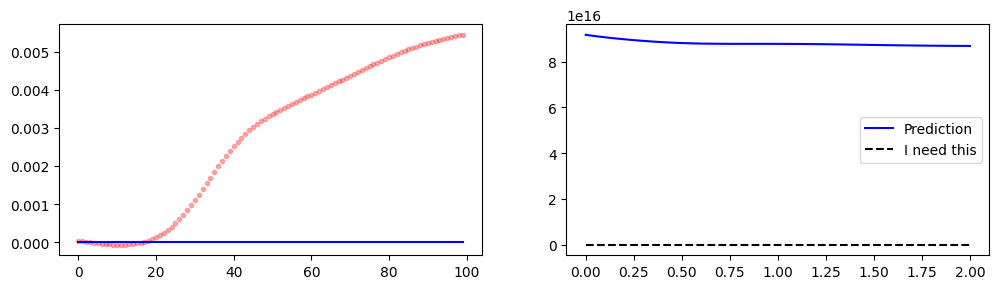

It  12/21 | mse = 1.17e-05 | loss = 1.17e+00 | dt = 0.2s | lr = 7.8e-02 | loss_mse = 1.2e+00 | loss_phys = 0.0e+00


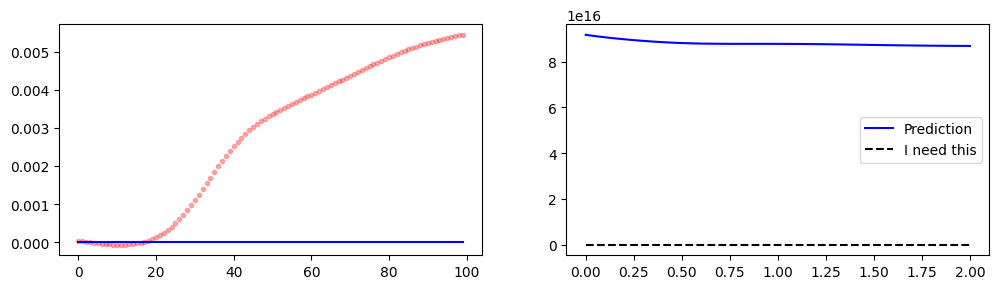

It  13/21 | mse = 1.17e-05 | loss = 1.17e+00 | dt = 0.1s | lr = 7.2e-02 | loss_mse = 1.2e+00 | loss_phys = 0.0e+00


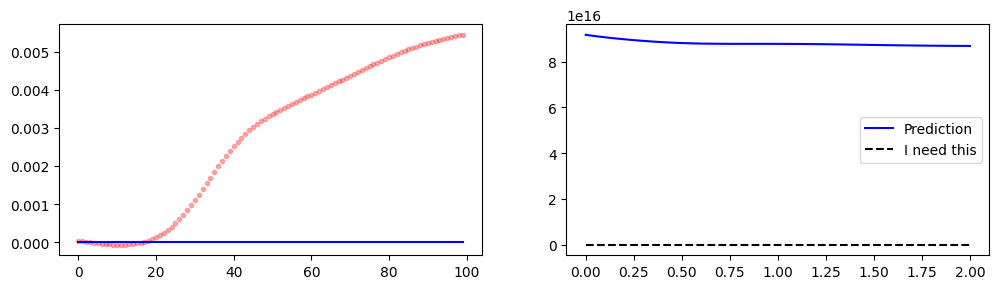

It  14/21 | mse = 1.17e-05 | loss = 1.17e+00 | dt = 0.1s | lr = 6.3e-02 | loss_mse = 1.2e+00 | loss_phys = 0.0e+00


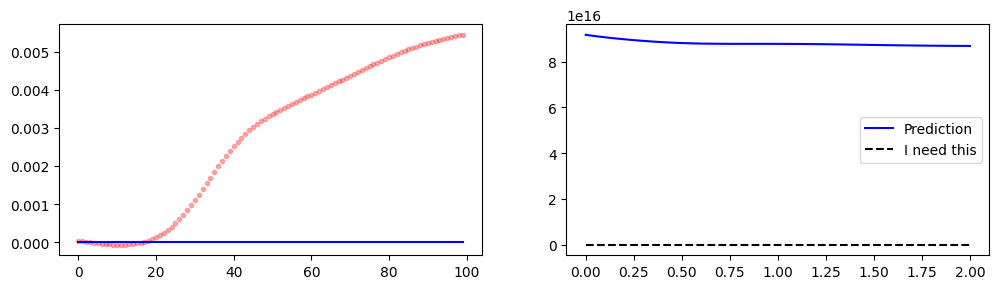

It  15/21 | mse = 1.17e-05 | loss = 1.17e+00 | dt = 0.1s | lr = 5.1e-02 | loss_mse = 1.2e+00 | loss_phys = 0.0e+00


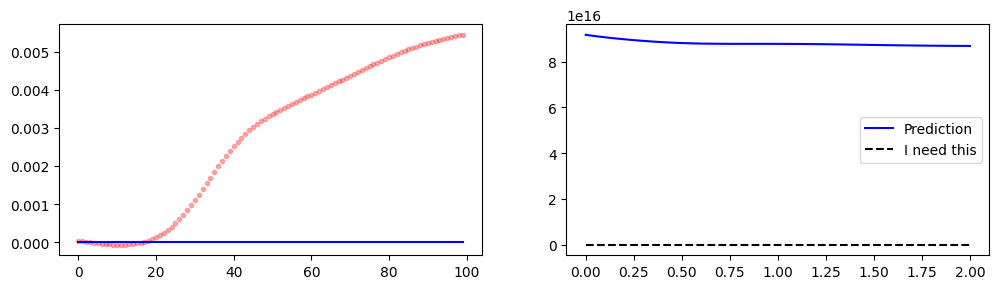

It  16/21 | mse = 1.17e-05 | loss = 1.17e+00 | dt = 0.1s | lr = 3.9e-02 | loss_mse = 1.2e+00 | loss_phys = 0.0e+00


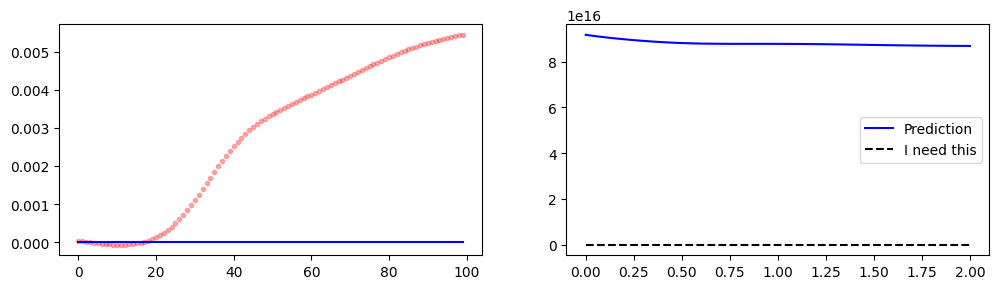

It  17/21 | mse = 1.17e-05 | loss = 1.17e+00 | dt = 0.1s | lr = 2.8e-02 | loss_mse = 1.2e+00 | loss_phys = 0.0e+00


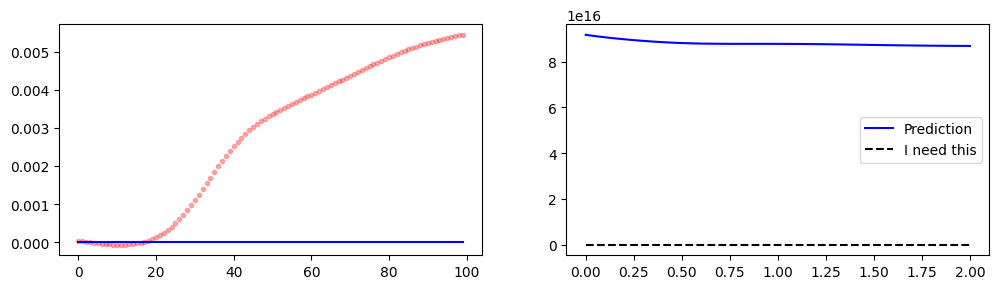

It  18/21 | mse = 1.17e-05 | loss = 1.17e+00 | dt = 0.1s | lr = 1.8e-02 | loss_mse = 1.2e+00 | loss_phys = 0.0e+00


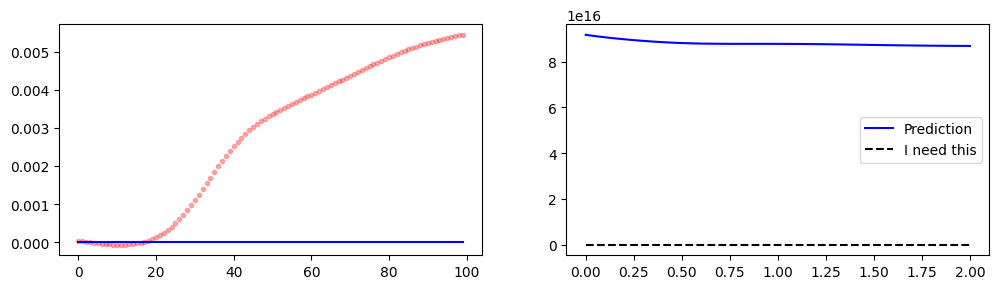

It  19/21 | mse = 1.17e-05 | loss = 1.17e+00 | dt = 0.1s | lr = 1.2e-02 | loss_mse = 1.2e+00 | loss_phys = 0.0e+00


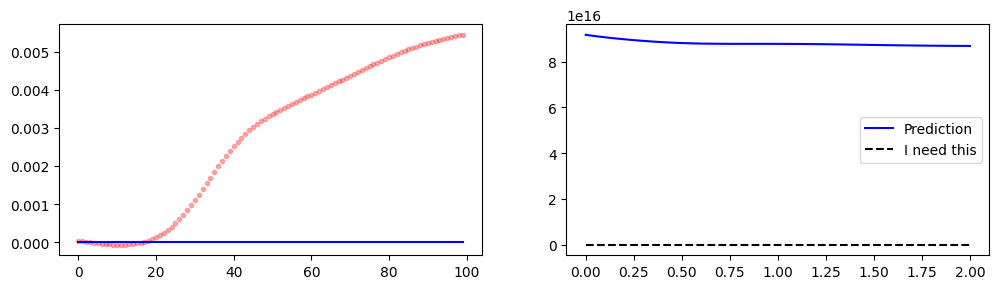

It  20/21 | mse = 1.17e-05 | loss = 1.17e+00 | dt = 0.1s | lr = 1.0e-02 | loss_mse = 1.2e+00 | loss_phys = 0.0e+00


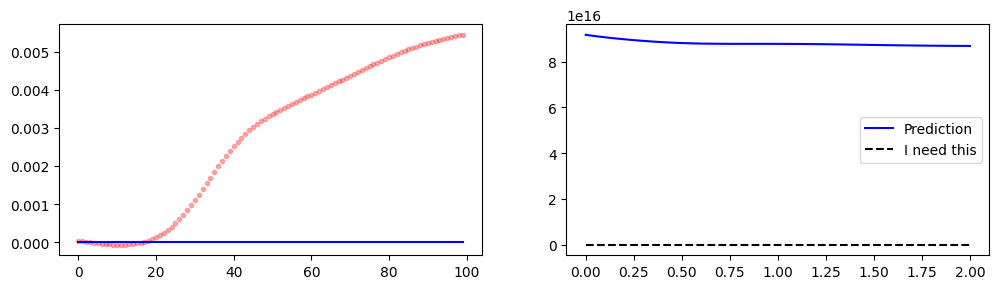

It  21/21 | mse = 1.17e-05 | loss = 1.17e+00 | dt = 0.1s | lr = 6.4e-02 | loss_mse = 1.2e+00 | loss_phys = 0.0e+00


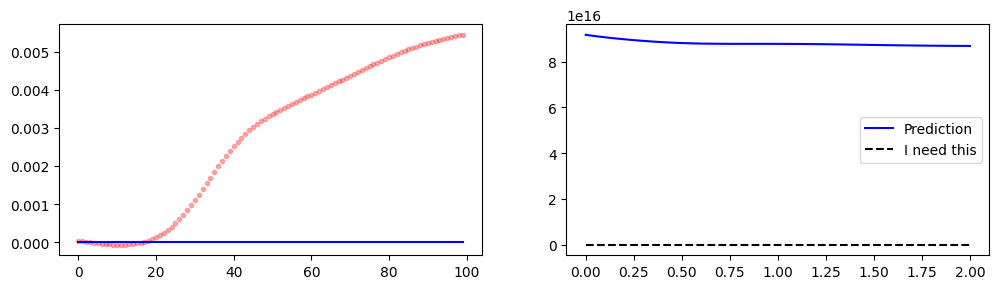

up_0.7
down_0.7
up_0.75
down_0.75
up_0.8
down_0.8
up_0.85
down_0.85
up_0.9
down_0.9
up_0.95
down_0.95


In [11]:
# for quantile, bound_up, bound_down in p3inn_core2_dir.iter_pred_PIs():
#     for bound_type, bound in [("up", bound_up), ("down", bound_down)]:
#         finn_p3inn_core2_dir = FinnDir(finn_exp_root / f"{bound_type}_{quantile:g}")
#         np.save(finn_p3inn_core2_dir.c_train_path, np.squeeze(bound))
#         t = np.linspace(
#             data_core2_df["time"].min(), data_core2_df["time"].max(), len(bound)
#         )
#         np.save(finn_p3inn_core2_dir.t_train_path, t)

#         print(f"{finn_p3inn_core2_dir.path.relative_to(finn_exp_root)}")
#         finn_fit_retardation(
#             out_dir=finn_p3inn_core2_dir.path,
#             is_exp_data=True,
#             n_epochs=21,
#             **conf_core2,
#         )

### Solve PDe with those Rs to get PI for concentration

In [12]:
# exp_dir = data_out_root / "experiments/p3inn_core2_finn"
# exp_dir.mkdir(exist_ok=True, parents=True)
# for finn_dir in map(FinnDir, finn_exp_root.iterdir()):
#     u_ret, ret = finn_dir.best_ret_points

#     # TODO: interp1D_torch uses linspace but we cannot be sure that u_ret is linearly spaced
#     assert np.array_equal(np.diff(u_ret), np.full(len(u_ret) - 1, u_ret[1] - u_ret[0]))

#     ret_tensor = torch.from_numpy(ret)
#     u_min = u_ret.min()
#     u_max = u_ret.max()

#     def ret_fun(c):
#         return interp1D_torch(ret_tensor, u_min, u_max, c)

#     c_ode = solve_diffusion_sorption_pde(
#         retardation_fun=ret_fun,
#         t=data_core2_df["time"].to_numpy(),
#         finn_params=FinnParams.from_dict(is_exp_data=True, **conf_core2),
#         c0=torch.from_numpy(np.load(finn_dir.c_train_path)[0]),
#     )

#     np.save(exp_dir / f"c_ode_{finn_dir.path.name}.npy", c_ode)


# Analyze

TODO

### Compare initial 95% PI3NN PI with "FINN-Data-Noise PI"
### Compare with MCMC PI